# PROMETHEE I & II Walkthrough: How to Choose the Best Job Offer

This notebook walks you through each step of PROMETHEE (I, II) when choosing the best job offer, using the same data and values as in the [blog post](https://medium.com/operations-research-bit/a-deep-dive-into-promethee-i-ii-how-to-choose-the-best-job-offer-2d0e21020146). 

## Table of Contents
1. [Setup](#setup)
2. [Step 1: Define Goal and Options](#goal-options)
3. [Step 2: Define the Evaluation Criteria](#criteria)
4. [Step 3: Build the Evaluation Matrix](#evaluation-matrix)
5. [Step 4: Assign Criteria Weights](#criteria-weights)
4. [Step 5: Choose Preference Functions](#preference-functions)
6. [Step 6: Calculate Preference Indices and Outranking Flows](#out-flows)
7. [Step 6.1: PROMETHEE I - Partial Ranking](#promethee-i)
8. [Step 6.2: PROMETHEE II - Complete Ranking](#promethee-ii)

## Setup 

We'll use the [`pyDecision`](https://github.com/Valdecy/pyDecision) Python library for calculations. You will also need the following Python libraries installed: pandas, matplotlib, numpy.

```python
# Install pyDecision and pandas, if you haven't done it already
# !pip install pyDecision --quiet
# !pip install pandas --quiet
# !pip install matplotlib --quiet
# !pip install numpy --quiet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## <a name="goal-options"></a>Step 1: Define Goal and Options

**Goal:** Choose the job offer that best fits your priorities and aligns with your values.

**Options/Alternatives (aka the decision set):**
- Job A: The Corporate Role
- Job B: The NGO Role
- Job C: The Consulting Role
- Job D: The Startup Role

In [2]:
# Options
options = ["Job A - Corporate", 
           "Job B - NGO", 
           "Job C - Consulting",
           "Job D - Startup"]

## <a name="criteria"></a>Step 2: Define the Evaluation Criteria

**Decision Criteria:**

_Quantitative:_
- Salary (€)
- Work Hours (hours/week)
- Commute Time (minutes)
- Travel Requirements (#trips/year)

_Qualitative:_
- Benefits (1-5 scale)
- Work-life Balance & Flexibility (1-5 scale)
- Learning & Growth Potential (1-5 scale)
- Company Culture (1-5 scale)
- Nature of Work (1-5 scale)

In [3]:
# Criteria
criteria = ["Salary (€)",
            "Work Hours (hrs/week)",
            "Commute Time (min)",
            "Travel (#trips/year)",
            "Work-Life Balance (1–5)",
            "Learning & Growth (1–5)",
            "Company Culture (1–5)",
            "Benefits (1–5)",
            "Nature of Work (1–5)"]

# Set the directions, i.e., how to evaluate each criteria. Some criteria we want to maximise (more is better = 1)
# and others we want to minimise (less is better = -1)
criteria_directions = [1, -1, -1, -1, 1, 1, 1, 1, 1]

## <a name="evaluation-matrix"></a>Step 3: Build the Evaluation Matrix

Here is the evaluation matrix for the job offers and the decision criteria:

In [4]:
evaluation_matrix = np.array([
    [90000, 50, 60,  2, 2, 2, 2, 5, 2],   # Job A - Corporate
    [50000, 40, 30, 10, 5, 4, 4, 3, 4],   # Job B - NGO
    [85000, 60, 15, 25, 2, 3, 3, 2, 3],   # Job C - Consulting
    [65000, 35,  0,  0, 5, 5, 5, 4, 5]    # Job D - Startup
])

df = pd.DataFrame(evaluation_matrix, index=options, columns=criteria)
df

,Salary (€),Work Hours (hrs/week),Commute Time (min),Travel (#trips/year),Work-Life Balance (1–5),Learning & Growth (1–5),Company Culture (1–5),Benefits (1–5),Nature of Work (1–5)
Job A - Corporate,90000,50,60,2,2,2,2,5,2
Job B - NGO,50000,40,30,10,5,4,4,3,4
Job C - Consulting,85000,60,15,25,2,3,3,2,3
Job D - Startup,65000,35,0,0,5,5,5,4,5


To use PROMETHEE properly, all criteria need to follow a "more is better" scale. For criteria that should be minimized (e.g., Work Hours, Commute Time), we subtract their values from the maximum observed. This way, all criteria can be interpreted using the same preference functions.

In [5]:
# Adjust the evaluation matrix values using the criteria directions
adjusted_evaluation_matrix = evaluation_matrix.copy()
for i, direction in enumerate(criteria_directions):
    if direction == -1:
        max_val = np.max(evaluation_matrix[:, i])
        adjusted_evaluation_matrix[:, i] = max_val - evaluation_matrix[:, i]

df_adj = pd.DataFrame(adjusted_evaluation_matrix, index=options, columns=criteria)
df_adj

,Salary (€),Work Hours (hrs/week),Commute Time (min),Travel (#trips/year),Work-Life Balance (1–5),Learning & Growth (1–5),Company Culture (1–5),Benefits (1–5),Nature of Work (1–5)
Job A - Corporate,90000,10,0,23,2,2,2,5,2
Job B - NGO,50000,20,30,15,5,4,4,3,4
Job C - Consulting,85000,0,45,0,2,3,3,2,3
Job D - Startup,65000,25,60,25,5,5,5,4,5


## <a name="criteria-weights"></a>Step 4: Assign Criteria Weights

Now, let's extract the weights for each criterion using AHP's eigenvector method. They must sum to 1.

Here's the pairwise comparisons matrix:

In [6]:
pairwise_matrix = np.array([
    [1,    7,    9,    7,    7,    5,    3,    7,    5],
    [1/7,  1,    3,    2,    0.5,  1/3,  1/5,  1/3,  1/5],
    [1/9, 1/3,   1,   0.5,   1/3,  1/5,  1/7,  1/5,  1/7],
    [1/7, 1/2,  2,     1,   1/3,  1/5,  1/7,  1/3,  1/5],
    [1/7, 2,    3,     3,     1,  0.5,  1/3,  0.5,  0.25],
    [1/5, 3,    5,     5,     2,    1,  1/3,    3,  0.5],
    [1/3, 5,    7,     7,     3,    3,    1,    5,    3],
    [1/7, 3,    5,     3,     2,  1/3,  1/5,    1,  1/3],
    [1/5, 5,    7,     5,     4,    2,  1/3,    3,    1]
])

In [7]:
from pyDecision.algorithm import ahp_method

weight_derivation = 'geometric'
criteria_weights, consistency_ratio = ahp_method(pairwise_matrix, wd = weight_derivation)

In [8]:
print("\nConsistency Ratio:", round(consistency_ratio, 2))
if (consistency_ratio > 0.10):
  print('The solution is inconsistent, the pairwise comparisons must be reviewed')
else:
  print('The solution is consistent, since the ratio is below the recommended 0.10 threshold.')


Consistency Ratio: 0.06
The solution is consistent, since the ratio is below the recommended 0.10 threshold.


In [9]:
criteria_weights_df = pd.DataFrame({
    "criteria": criteria,
    "criteria_weights": np.round(criteria_weights, 3)
})

display(criteria_weights_df)

,criteria,criteria_weights
0,Salary (€),0.359
1,Work Hours (hrs/week),0.037
2,Commute Time (min),0.019
3,Travel (#trips/year),0.026
4,Work-Life Balance (1–5),0.053
5,Learning & Growth (1–5),0.099
6,Company Culture (1–5),0.206
7,Benefits (1–5),0.064
8,Nature of Work (1–5),0.137


Check if the sum of all criteria weights is 1

In [10]:
criteria_weights_df["criteria_weights"].sum()

1.0

In [11]:
criteria_weights_df.sort_values(by="criteria_weights", ascending=False)

,criteria,criteria_weights
0,Salary (€),0.359
6,Company Culture (1–5),0.206
8,Nature of Work (1–5),0.137
5,Learning & Growth (1–5),0.099
7,Benefits (1–5),0.064
4,Work-Life Balance (1–5),0.053
1,Work Hours (hrs/week),0.037
3,Travel (#trips/year),0.026
2,Commute Time (min),0.019


The most important criteria are:
- Salary
- Company Culture
- Nature of Work

The least important criteria are:
- Commute Time
- Travel requirements
- Work Hours 

## <a name="preference-functions"></a>Step 5: Choose Preference Functions (and Thresholds)

Preference functions tell you how to interpret differences between options for a given criterion.
They define when a difference is too small to matter, and when it's large enough to count as a clear preference.

Each criterion is assigned its own preference function, along with thresholds (`q`, `p`) that define the cutoff points for indifference and strong preference:

            
| Criterion | Function | q (Indifference) | p (Preference) |
|-----------|----------|---|---|
| Salary | V-shape with Indifference (t5) | 10 000 € | 30 000 € |
| Work Hours | V-shape (t3) | – | 5 hrs |
| Commute Time | U-shape (t2) | 0 min | – |
| Travel Requirements | V-shape (t3) | – | 3 trips |
| Work-Life Balance | Level (t4) | 2 | 5 |
| Learning & Growth | Level (t4) | 2 | 4 |
| Company Culture | U-shape (t2) | 3 | – |
| Benefits | Level (t4) | 2 | 4 |
| Nature of Work | U-shape (t2) | 2 | – |

In the library we’re using (pyDecision), these preference functions are referenced using the following codes:
- **t1:** Usual
- **t2:** U-shape
- **t3:** V-shape
- **t4:** Level
- **t5:** V-shape with indifference
- **t6:** Gaussian

In [12]:
# Indifference thresholds (q)
Q = [10000,     # Salary
     None,     # Work Hours
     0,        # Commute Time
     None,     # Travel Requirements
     2,        # Work-Life Balance
     2,        # Learning & Growth
     3,        # Company Culture
     2,        # Benefits
     2]        # Nature of Work

# Preference thresholds (p)
P = [30000,    # Salary
     5,        # Work Hours
     None,     # Commute Time
     3,        # Travel Requirements
     5,        # Work-Life Balance
     4,        # Learning & Growth
     None,     # Company Culture
     4,        # Benefits
     None]     # Nature of Work

# Gaussian thresholds (s)
S = [None, # Salary
     None, # Work Hours
     None, # Commute Time
     None, # Travel Requirements
     None, # Work-Life Balance
     None, # Learning & Growth
     None, # Company Culture
     None, # Benefits
     None] # Nature of Work

# Preference function types (F) according to pyDecision:
# t1: Usual, t2: U-shape, t3: V-shape, t4: Level, t5: V-shape with indifference, t6: Gaussian
F = ['t5',     # Salary
     't3',     # Work Hours
     't2',     # Commute Time
     't3',     # Travel Requirements
     't4',     # Work-Life Balance
     't4',     # Learning & Growth
     't2',     # Company Culture
     't4',     # Benefits
     't2']     # Nature of Work

W = criteria_weights_df["criteria_weights"]

## <a name="out-flows"></a>Step 6: Calculate Preference Indices and Outranking Flows

Once the criteria weights, preference functions and corresponding thresholds are set, we can start comparing the job offers using PROMETHEE.

For each pair of options, the method calculates how much one option is preferred over the other, based on all criteria and the stated preferences. These are called **preference indices**.

We'll start with **PROMETHEE I**, which calculates how much each job offer outranks or is outranked by the others. This gives us:
- **Positive outranking flow ($ϕ⁺$):** how much an option outranks the others
- **Negative outranking flow ($ϕ⁻$):** how much it is outranked by the others

Later, we'll use **PROMETHEE II**, which ranks all options using only the:
- **Net outranking flow ($ϕ$):** the difference between the positive and negative flows, showing overall performance of an option.

## <a name="promethee-i"></a>Step 6.1: PROMETHEE I - Partial Ranking

PROMETHEE I is the partial ranking version of the PROMETHEE family of methods. It compares each pair of options (job offers) across all criteria and calculates how much one is preferred over the other. It uses both the positive and negative outranking flows to generate a ranking. 

The result can be a _partial ranking_: some options may be deemed incomparable if the trade-offs between them are balanced.

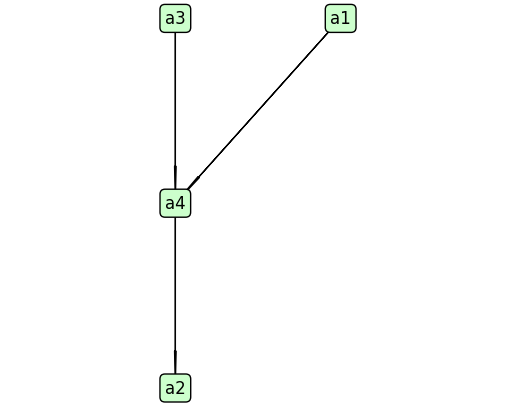

In [13]:
# Run PROMETHEE I to compute preference flows
from pyDecision.algorithm import promethee_i

p1 = promethee_i(adjusted_evaluation_matrix, 
                 W = W, 
                 Q = Q, 
                 S = S, 
                 P = P, 
                 F = F, 
                 graph = True)

### Interpretation of PROMETHEE I Graph:

The graph above shows the PROMETHEE I partial ranking of the four job offers.

PROMETHEE I doesn't produce a strict full ranking of all job offers. Instead, it reveals where clear preferences exist and where they don’t.

To interpret the graph you should know the following:

**1. Each node represents a job:**
- `a1`: Job A (Corporate)
- `a2`: Job B (NGO)
- `a3`: Job C (Consulting)
- `a4`: Job D (Startup)

**2. Arrows indicate preference:**
- An arrow from `a3` -> `a4` means Job C (Consulting) is preferred over Job D (Startup).
- An arrow from `a1` -> `a4` means Job A (Corporate) is also preferred over Job D (Startup).
- An arrow from `a4` -> `a2` means Job D (Startup) is preferred over Job B (NGO).
- The absence of arrows between some jobs (e.g., between `a1` and `a3`, or `a1` and `a2`) indicates **incomparability** due to **trade-offs that offset one another**.

**From the analysis we conclude:**
- Job A (Corporate) is not directly comparable to either Job C (Consulting) or Job B (NGO). This means their strengths and weaknesses balance each other out depending on the criteria, and PROMETHEE I cannot declare one better than the other.
- Job C (Consulting) and Job A (Corporate) are both preferred over Job D (Startup).
- Job D (Startup) is preferred over Job B (NGO), which is the only job that is clearly outranked by the others.


In [14]:
display(pd.DataFrame(p1, index=options, columns=options))

,Job A - Corporate,Job B - NGO,Job C - Consulting,Job D - Startup
Job A - Corporate,-,P+,R,P+
Job B - NGO,-,-,-,-
Job C - Consulting,R,P+,-,P+
Job D - Startup,-,P+,-,-


### Interpretation of PROMETHEE I Results Table:

This table summarizes the pairwise preference relationships between job offers using the PROMETHEE I method. 

How to read it:
- `P+`: Row job is preferred over the column job.
- `R`: The two jobs are incomparable (neither is clearly preferred)
- `-`: No preference (the diagonal or no relation)

**How to interpret:**
1. **Job A (Corporate):**
   - Preferred over Job B (NGO) -> `P+`
   - Incomparable with Job C (Consulting) -> `R`
   - Preferred over Job D (Startup) -> `P+`
2. **Job B (NGO):**
   - Has no strong preference relationships with any of the others.
   - This likely means Job B is outranked, or weak overall, and not preferred in any pairwise comparison.
3. **Job C (Consulting):**
   - Incomparable with Job A (Corporate) -> `R`
   - Preferred over Job B (NGO) -> `P+`
   - Preferred over Job D (Startup) -> `P+`
4. **Job D (Startup):**
   - Preferred over Job B (NGO) -> `P+`
  
**Summary:**
- Job A (Corporate) is preferred over two jobs (B and D), but cannot be ranked against C, meaning there's a trade-off between jobs A and C that prevents a clear preference.
- Job B (NGO) is outranked by all the other job offers.
- Job C (Consulting) is preferred over two jobs (B and D), but incomparable with Job A (Corporate), suggesting a similar trade-off as Job A.
- Job D ranks above only Job B, indicating that while it's better than one option, it's not the top choice.

**Conclusions:**
- The best-ranked jobs in terms of preference count:
  - Job A (Corporate) and Job C (Consulting).
- Job A (Corporate) vs. Job C (Consulting) are **incomparable**, highlighting a meaningful trade-off, which makes sense. Job A dominates financially (both salary and benefits), but Job C is a better fit in terms of nature of work and company culture.
- Job B (NGO) is the least preferred overall.
- Job D (Startup) is better than Job B (NGO), but worse than Job A (Corporate) and Job C (Consulting).

#### The Preference Matrix

In [15]:
from pyDecision.algorithm.p_i import preference_degree

# Compute preference matrix
preference_matrix = preference_degree(adjusted_evaluation_matrix, W=W, Q=Q, S=S, P=P, F=F)

preference_matrix_df = pd.DataFrame(preference_matrix, index=options, columns=options)
display(preference_matrix_df.round(3))

,Job A - Corporate,Job B - NGO,Job C - Consulting,Job D - Startup
Job A - Corporate,0.000,0.385,0.095,0.269
Job B - NGO,0.082,0.000,0.090,0.000
Job C - Consulting,0.019,0.378,0.000,0.180
Job D - Startup,0.286,0.172,0.108,0.000


#### Compute and Plot the Positive and Negative Outranking Flows

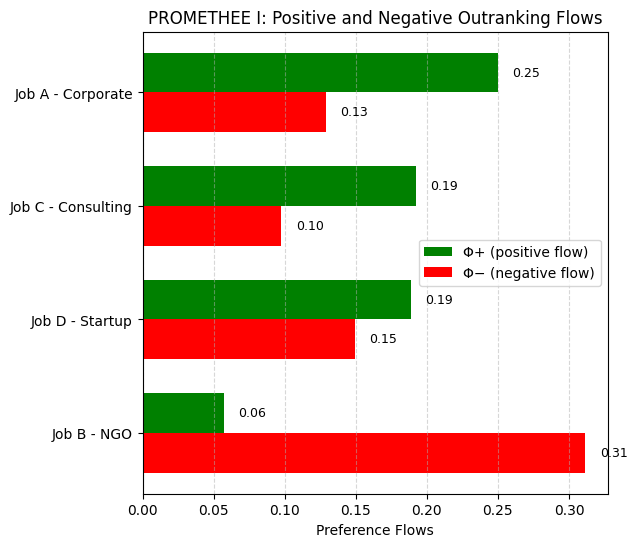

In [16]:
# Compute outranking flows (Phi⁺, Phi⁻)
n = preference_matrix.shape[0]
# Positive outranking flow (Phi⁺): average preference over others
phi_plus = preference_matrix.sum(axis=1) / (n - 1)
# Negative outranking flow (Phi⁻): average preference others have over each
phi_minus = preference_matrix.sum(axis=0) / (n - 1)

# Sorting for visualization
sorted_indices = np.argsort(-phi_plus)
options_sorted = [options[i] for i in sorted_indices]
phi_plus_sorted = phi_plus[sorted_indices]
phi_minus_sorted = phi_minus[sorted_indices]

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))
y_pos = np.arange(len(options_sorted))

# Plot vertical bars
bar_width = 0.35
ax.barh(y_pos - bar_width/2, phi_plus_sorted, height=bar_width, color='green', label='Φ+ (positive flow)')
ax.barh(y_pos + bar_width/2, phi_minus_sorted, height=bar_width, color='red', label='Φ− (negative flow)')

# Annotate values
for i, (pp, pm) in enumerate(zip(phi_plus_sorted, phi_minus_sorted)):
    ax.text(pp + 0.01, i - bar_width/2, f'{pp:.2f}', va='center', fontsize=9, color='black')
    ax.text(pm + 0.01, i + bar_width/2, f'{pm:.2f}', va='center', fontsize=9, color='black')

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(options_sorted)
ax.invert_yaxis()
ax.set_xlabel('Preference Flows')
ax.set_title('PROMETHEE I: Positive and Negative Outranking Flows')
ax.legend(loc='best')

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [17]:
df_flows = pd.DataFrame({
    'Job Offer': options,
    'Phi+': np.round(phi_plus, 3),
    'Phi−': np.round(phi_minus, 3),
})
df_flows.reset_index(drop=True, inplace=True)
df_flows

,Job Offer,Phi+,Phi−
0,Job A - Corporate,0.250,0.129
1,Job B - NGO,0.057,0.312
2,Job C - Consulting,0.192,0.098
3,Job D - Startup,0.189,0.150


In this table, we can see that Job B (NGO) is clearly outranked by all the other job offers, because its negative flow is significantly higher than its positive flow.

## <a name="promethee-ii"></a>Step 6.2: PROMETHEE II - Complete Ranking

PROMETHEE II builds on PROMETHEE I by calculating a **net flow score** for each option:

$ϕ = ϕ⁺ − ϕ⁻$

This generates a **complete ranking**, even when trade-offs exist. 

Unlike PROMETHEE I, there are no ties or incomparables since each option gets a single score and a clear position in the ranking.

**Note:** Only use PROMETHEE II when you need a final decision and want to rank all options from best to worst.

a1: 0.12
a3: 0.095
a4: 0.039
a2: -0.254


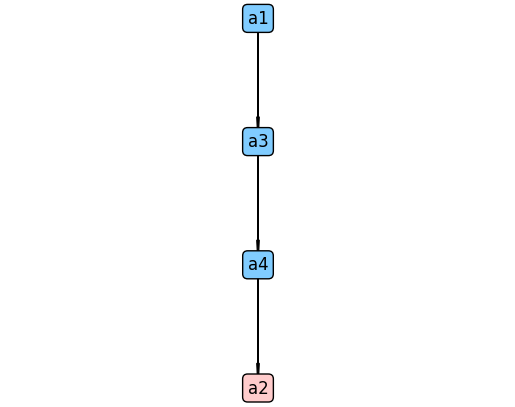

In [18]:
# Run PROMETHEE II to compute preference flows
from pyDecision.algorithm import promethee_ii

p2 = promethee_ii(adjusted_evaluation_matrix, 
                  W = W, 
                  Q = Q, 
                  S = S, 
                  P = P, 
                  F = F,
                  sort = True, 
                  topn = 10, 
                  graph = True, 
                  verbose = True)

### Interpretation of PROMETHEE II Graph:

The graph above shows the PROMETHEE II complete ranking of the four job offers.

Unlike PROMETHEE I, which shows partial preferences and possible incomparabilities, PROMETHEE II aggregates all information into a single **net flow score (Φ)** for each job. This produces a strict, complete ranking, from most to least preferred.

To interpret the graph you should know the following:

**1. Each node represents a job:**
- `a1`: Job A (Corporate)
- `a2`: Job B (NGO)
- `a3`: Job C (Consulting)
- `a4`: Job D (Startup)

**2. Arrows indicate the complete ranking from best to worst:**
- Arrows point from the most preferred job offer (`a1` - Job A) to the least preferred job offer (`a2` - Job B).

**3. Colors indicates desirability of each option:**
- Colors help visualise performance: blue = strong (positive net flow), red = weak (negative net flow)
- Blue nodes (`a1` - Job A, `a3` - Job C, `a4` - Job D) represent options with positive net flow (Φ > 0). These jobs are generally more preferred since they outrank more job offers than they are outranked by.
- Red/pink nodes (`a2`) represent job offers with negative net flow (Φ < 0). In this case, Job B is less preferred, since it is outranked by others more often than it outranks them.

**How to interpret the graph:**
- The higher the net flow, the better the overall ranking.
- The arrows show which options outrank others.
- Colors help visualise performance: blue = strong (positive net flow), red = weak (negative net flow).

**From the analysis we conclude:**
- Job A (Corporate) ranks highest overall, with the strongest net flow (Φ = 0.12) meaning it outranks the other job offers more than it is outranked.
- Job C (Consulting) comes next, followed closely by Job D (Startup).
- Job A (Corporate), Job C (Consulting), and Job D (Startup) are all viewed positively overall (blue nodes).
- Job B (NGO) is clearly the weakest option according to the PROMETHEE II net flow, with a clearly negative net flow (Φ = −0.254), confirming it is outranked by all others (red/pink node).
- The ordering of the job offers is strict, without incomparabilities.

**Final ranking:**

```
Job A (Corporate) > Job C (Consulting) > Job D (Startup) > Job B (NGO)
```

This means that, overall and taking all trade-offs into account, Job A (Corporate) is the most balanced and preferable option according to the decision maker's criteria weights and stated preferences, even if it may not dominate in every single criterion.

In [19]:
# Net flow (Phi): Phi⁺ - Phi⁻
phi_net = phi_plus - phi_minus

df_flows = pd.DataFrame({
    'Job Offer': options,
    'Phi+': np.round(phi_plus, 3),
    'Phi−': np.round(phi_minus, 3),
    'Net Flow (Φ)': np.round(phi_net, 3)
})
df_flows.sort_values(by='Net Flow (Φ)', ascending=False, inplace=True)
df_flows.reset_index(drop=True, inplace=True)
df_flows

,Job Offer,Phi+,Phi−,Net Flow (Φ)
0,Job A - Corporate,0.250,0.129,0.120
1,Job C - Consulting,0.192,0.098,0.095
2,Job D - Startup,0.189,0.150,0.039
3,Job B - NGO,0.057,0.312,-0.254


## Options Ranked!

| Job Offers   | Net Flow (Φ) |
|---------|----------------------|
| Job A - Corporate | 0.12 |
| Job C - Consulting | 0.095 |
| Job D - Startup | 0.039 |
| Job B - NGO | −0.254 |

**Conclusion:**  
And the winner is… Job offer A! The Corporate Role represents the best compromise solution for this decision problem.